In [1]:
import numpy as np
import scipy as sp
import matplotlib
from matplotlib import pyplot as plt
%matplotlib notebook
from tqdm import tqdm_notebook as tqdm
import tabulate
from IPython.display import display, HTML, Markdown
from scipy.spatial.distance import cdist as dist
from notebook_functions import open_file_dialog, read_h5_data, blue, orange
import scipy.signal
from scipy.fftpack import fft, ifft, fftfreq

############# SCRIPT PARAMETERS #############

data_set = 'vdc_8'
rho = 1000.
c = 1500.
pos = [0, 0, 0.05]
flow = 5e6
fhigh = 10e6
forder = 6

#############################################

path_to_file = open_file_dialog()

parameters = {'File': path_to_file,
              'Dataset': data_set,
              'Density (kg/m^3)': rho,
              'Sound speed (m/s)': c,
              'Field position (m)': pos,
              'Filter low (MHz)': flow/1e6,
              'Filter high (MHz)': fhigh/1e6,
              'Filter order': forder
             }

# display(Markdown('### <center> Notebook parameters </center>'))
display(HTML('<center>' + tabulate.tabulate(parameters.items(), tablefmt='html') + '</center>'))

File,D:/Data/full_vernier_tx_9x9_data.h5
Dataset,vdc_8
Density (kg/m^3),1000.0
Sound speed (m/s),1500.0
Field position (m),"[0, 0, 0.05]"
Filter low (MHz),5.0
Filter high (MHz),10.0
Filter order,6


In [2]:
## load data from file
if path_to_file is not None:
    data = read_h5_data(path_to_file, data_set, add_zero_freq=True, minimal=True)

<IPython.core.display.Javascript object>


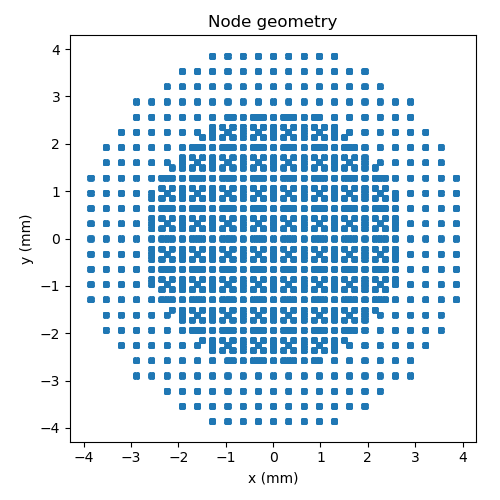

In [3]:
## get nodes
nodes = data['nodes']

## node plot
plt.figure(figsize=(5, 5))
plt.plot(nodes[:,0] / 1e-3, nodes[:,1] / 1e-3, '.', markersize=1)
plt.gca().set_aspect('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('Node geometry');
plt.tight_layout()

<IPython.core.display.Javascript object>


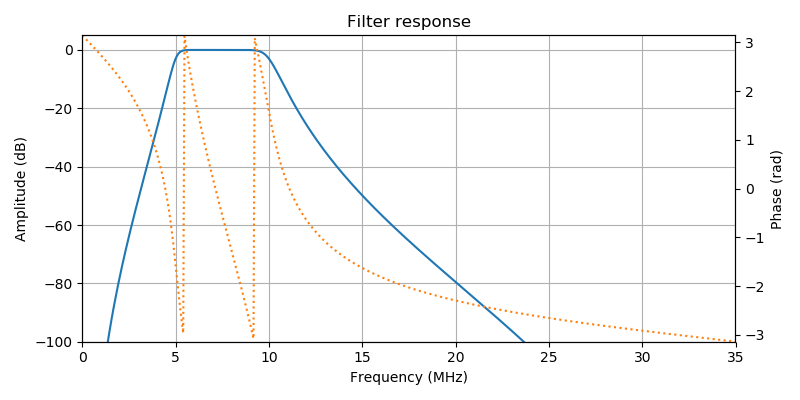

In [4]:
freqs = data['freqs']
nfreqs = len(freqs)

## create bandpass filter
fs = (freqs[1] - freqs[0]) * nfreqs * 2
nyq = fs / 2
f1 = flow / nyq
f2 = fhigh / nyq

b, a = sp.signal.butter(forder, [f1, f2], btype='bandpass')
w, h = sp.signal.freqz(b, a)

## filter response plot
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
tax = ax.twinx()
ax.plot(w / (2 * np.pi) * fs / 1e6, 20 * np.log10(np.abs(h)), color=blue)
tax.plot(w / (2 * np.pi) * fs / 1e6, np.angle(h), ls=':', color=orange)
ax.set_ylim(-100, 5)
tax.set_ylim(-np.pi, np.pi)
ax.margins(0, 0.1)
ax.set_title('Filter response')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Amplitude (dB)')
ax.grid('on')
tax.set_ylabel('Phase (rad)')
plt.tight_layout()

In [5]:
def convert_to_2sided(f, s):
    
    s = np.atleast_2d(s)
    
    npos, nf = s.shape
    nfft = (nf - 1) * 2

    s2s = np.zeros((npos, nfft), dtype=np.complex128)
    s2s[:, :nfft//2] = s[:, :-1]
    s2s[:, nfft//2:] = np.conj(s[:, -1:0:-1])

    df = f[1] - f[0]
    fs = df * nfft 
    f2s = fftfreq(nfft, 1 / fs)
    
    return f2s, s2s.squeeze()

## calculate pressure frequency response
nodes = data['nodes']
freqs = data['freqs']
x = data['x']
node_area = data['node_area']

pos, nodes = np.atleast_2d(pos, nodes)
nfreqs = len(freqs)
p = np.zeros(nfreqs, dtype=np.complex128)
    
d = dist(pos, nodes)

for i, f in tqdm(enumerate(freqs), total=nfreqs):

    k = 2*np.pi*f/c
    q = node_area*1j*2*np.pi*f*x[:,i]*2 # 2x for baffled condition

    p[i] = np.sum(1j*k*rho*c/(4*np.pi)*np.exp(-1j*k*d)/d*q, -1).squeeze()

A Jupyter Widget

<IPython.core.display.Javascript object>


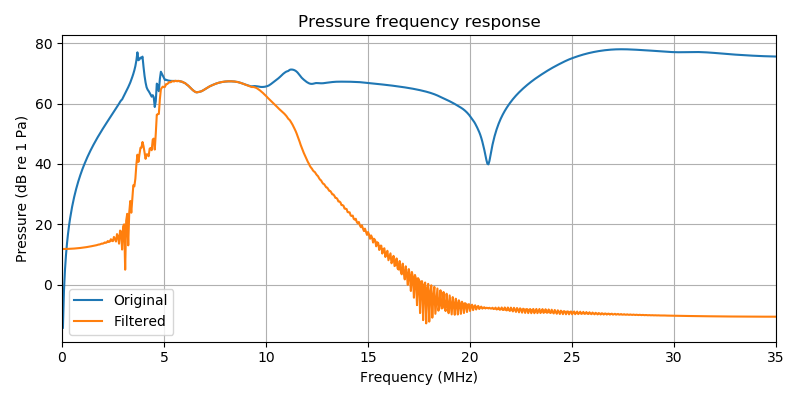

<IPython.core.display.Javascript object>


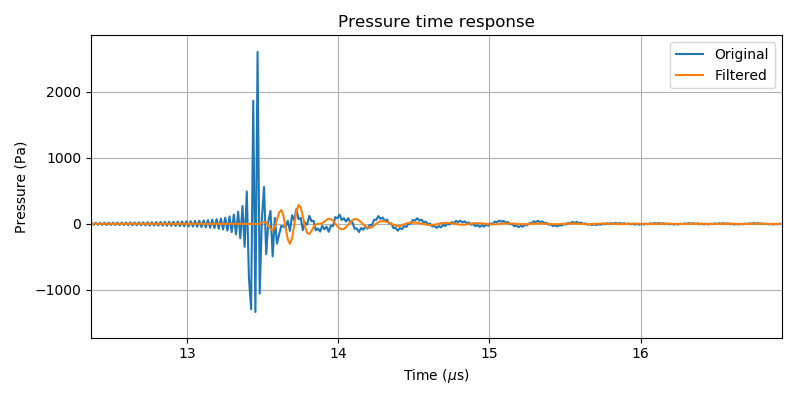

In [6]:
np.seterr(divide='ignore')

## calculate time domain unfiltered and filtered responses
freqs2s, p2s = convert_to_2sided(freqs, p)

pt = np.real(ifft(p2s)) # fs factor to convert spectral density to time?
ptfilt = sp.signal.lfilter(b, a, pt)

t = np.arange(len(pt)) / fs

# calculate frequency response
cutoff = (nfreqs + 1) // 2
pfilt = fft(ptfilt)[:nfreqs] 

# pressure frequency domain plot
plt.figure(figsize=(8, 4))
plt.plot(freqs / 1e6, 20 * np.log10(np.abs(p)));
plt.plot(freqs / 1e6, 20 * np.log10(np.abs(pfilt)))
plt.xlim(0, freqs.max() / 1e6);
plt.xlabel('Frequency (MHz)');
plt.ylabel('Pressure (dB re 1 Pa)');
plt.title('Pressure frequency response')
plt.legend(['Original','Filtered'])
plt.grid('on')
plt.tight_layout()

# pressure time domain plot
plt.figure(figsize=(8, 4))
plt.plot(t / 1e-6, pt)
plt.plot(t / 1e-6, ptfilt)
plt.xlabel('Time ($\mu$s)');
plt.ylabel('Pressure (Pa)');
plt.margins(0, 0.1)
plt.title('Pressure time response')
plt.grid('on');
plt.legend(['Original','Filtered'])
plt.tight_layout()